Estimate parameters for resampling procedure (trial generation).

* Number of resampling iterations: M is based on bootstrapping stability analysis 
* Number of trials per resampling: N = 40 (based on data in monkey dataset so the number of trials is from experiments)

#### Bootstrapping Stability Analysis (for M)

We determine a reasonable M by checking when the median stabilizes (using median because IT distribution is skewed):

1. Compute the median and the sem equivalent for median (using MAD - median absolute deviation) of intrinsic timescales as M increases.
2. Plot the standard error of the median vs. M.
3. Pick M where SE and its 95% confidence interval are under 25ms.

Run for M = [50, 100, 200, 500, 1000]

#### Selecting number of signals for M estimate

Spike trains are coming from different brain areas and may have different variance so using only one is not gut. The total number of signals and the min per area number of signals are set. After sampling the min number per area the rest is sampled proportionally to the number of signals in the area.

Min number per area: 10
N total: 100 (97)

In [1]:
import csv
import sys
import pickle
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
from calculate_acf import acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trial_concat
from spike_train_utils import bin_spike_train_fixed_len, get_trials, bin_trials
os.chdir(current_wd)

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

In [4]:
estimate_m = False
save_fig = True

### Get data

In [ ]:
if estimate_m:
    csv_data_file = dataset_folder + 'sua_list_constrained.csv'
    with open(csv_data_file, newline='') as f:
        reader = csv.reader(f)
        sua_list = list(reader)
    print(f'Loaded N units {len(sua_list)}')

In [5]:
units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
units_info_df.head(2)

,specimen_id,session_id,unit_id,ecephys_structure_acronym,firing_rate,amplitude_cutoff,isi_violations,presence_ratio,fr_hz_spont_30min,fr_hz_spont_30min_log10
66,744912849,766640955,950913540,VISam,5.924830,0.004951,0.157933,0.99,6.038333,0.780917
67,744912849,766640955,950915005,VISam,4.549072,0.001203,0.096072,0.99,4.030556,0.605365


### Estimate M

#### Run bootstrapping

In [ ]:
def sample_signals(units_df, min_per_area, n_total):
    sampled_units = []

    area_counts = units_df["ecephys_structure_acronym"].value_counts()
    base_samples = {area: min(min_per_area, count) for area, count in area_counts.items()}
    remaining_samples = n_total - sum(base_samples.values())
    total_remaining = sum(area_counts) - sum(base_samples.values())
    print(f'total {n_total}, min per area {min_per_area}. Base samples {base_samples}, \nproportional samples {remaining_samples}')
    
    # get min_per_area, then sample proportionally
    for area, count in area_counts.items():
        base_samples = min(min_per_area, count)
        extra_samples = int((count / total_remaining) * remaining_samples) if total_remaining > 0 else 0
        n_samples = base_samples + extra_samples
        sampled_units.extend(units_info_df[units_info_df["ecephys_structure_acronym"] == area]
                             .sample(n=min(n_samples, count), random_state=42)["unit_id"].tolist())
    
    return sampled_units

In [ ]:
if estimate_m:
    fs = 30000
    signal_len = int(30 * 60 * fs)
    n_lags = 20
    bin_size = 50 # in ms
    trial_len = int(n_lags * bin_size * (fs/1000))
    
    n_trials = 40 # this is fixed based on experimental datasets
    m_iterations = [20, 40, 60, 80, 100, 150, 200, 500, 1000]
    
    n_total_signals = 100
    min_signal_per_area = 10

In [ ]:
if estimate_m:
    units_to_sample = sample_signals(units_info_df, min_signal_per_area, n_total_signals)
    random_signals = [item for item in sua_list if item[2] in units_to_sample]
    
    output_log = dataset_folder + f'resampling//resampling_params_estimate_{n_signals}_signals.txt'
    old_stdout = sys.stdout
    sys.stdout = open(output_log, 'w')
    
    signal_tau_dict = {}
    
    for signal_idx, signal in enumerate(random_signals):
        print(f'###\nCalculating for {signal_idx} signal')
        spikes = np.asarray([int(spike) for spike in signal[8:]])
    
        tau_dict = {}
        for m_iteration in m_iterations:
            print(f'calculating for {m_iteration} resampling iterations')
            tau_l = []
            for m in range(m_iteration):
                spikes_trials = get_trials(spikes, signal_len, n_trials, trial_len, verbose_=False)
                spikes_trials_binned = bin_trials(spikes_trials, trial_len, int(bin_size*(fs/1000)))
                # get taus
                _, acf_average = acf_pearsonr_trial_avg(spikes_trials_binned, n_lags, verbose_=False)
                _, _, tau, _, _, _, _ = fit_single_exp(acf_average, start_idx_=1, exp_fun_=func_single_exp_monkey)
                tau_l.append(tau)
            tau_dict[m_iteration] = tau_l
            
        signal_tau_dict[signal[2]] = tau_dict
    
    with open(dataset_folder + f'resampling//signal_tau_dict_{n_signals}_signals.pkl', "wb") as f:
        pickle.dump(signal_tau_dict, f)
    
    sys.stdout = old_stdout

#### Find M

In [ ]:
# with open(dataset_folder + f'resampling//signal_tau_dict_100_signals_pearsonr.pkl', "rb") as f:
#     signal_tau_dict = pickle.load(f)
# signal_tau_dict.keys()
# print(f'N signals {len(signal_tau_dict)}')

In [6]:
with open(dataset_folder + f'resampling//signal_tau_dict_100_signals_pearsonr_avg.pkl', "rb") as f:
    pearsonr_avg_dict = pickle.load(f)
pearsonr_avg_dict.keys()
print(f'N signals {len(pearsonr_avg_dict)}')

with open(dataset_folder + f'resampling//signal_tau_dict_100_signals_sttc_avg.pkl', "rb") as f:
    sttc_avg_dict = pickle.load(f)
sttc_avg_dict.keys()
print(f'N signals {len(sttc_avg_dict)}')

with open(dataset_folder + f'resampling//signal_tau_dict_100_signals_sttc_concat.pkl', "rb") as f:
    sttc_concat_dict = pickle.load(f)
sttc_concat_dict.keys()
print(f'N signals {len(sttc_concat_dict)}')

# signals = list(signal_tau_dict.keys())
signals_pearsonr_avg = list(pearsonr_avg_dict.keys())
signals_sttc_avg = list(sttc_avg_dict.keys())
signals_sttc_concat = list(sttc_concat_dict.keys())
signals_pearsonr_avg == signals_sttc_avg == signals_sttc_concat # elements and order are identical

N signals 97
N signals 97
N signals 97


True

In [7]:
# in dict for each iteartion list of taus is stored
def get_tau_df_v1(tau_dict_, units_info_df_):
    signal_l = []
    m_iterations_l = []
    tau_nanmedian_l = []
    sem_tau_median_l = []
    
    for k, v in tau_dict_.items():
        for kk, vv in v.items():
            vv_nan_removed = [x for x in vv if not np.isnan(x)]
            if len(vv_nan_removed) < 1:
                print(len(vv_nan_removed))
                tau_med = np.nan
                tau_sem_median = np.nan
            # median based
            else:
                tau_med = np.nanmedian(vv_nan_removed)
                tau_mad = np.nanmedian(np.abs(vv_nan_removed - tau_med)) # median absolute deviation
                tau_sem_median = (1.4826 * tau_mad) / np.sqrt(len(vv_nan_removed)) # sem of sorts
            
            signal_l.append(k)
            m_iterations_l.append(kk)
            tau_nanmedian_l.append(tau_med)
            sem_tau_median_l.append(tau_sem_median)
    
    tau_df = pd.DataFrame({
        "signal": signal_l,
        "m_iterations": m_iterations_l,
        "tau_nanmedian": tau_nanmedian_l,
        'tau_sem_median': sem_tau_median_l
    })
    tau_df['tau_sem_median_ms'] = tau_df['tau_sem_median'] * 50

    # add info about brain area
    units_info_df_subset = units_info_df_[['unit_id', 'ecephys_structure_acronym']].copy()
    tau_df.rename(columns={'signal':'unit_id'}, inplace=True)
    tau_df = pd.merge(tau_df, units_info_df_subset, on='unit_id', how='left')

    return tau_df

# in dict for each iteartion list of {} with all info is stored
def get_tau_df_v2(tau_dict_, units_info_df_):
    signal_l = []
    m_iterations_l = []
    tau_nanmedian_l = []
    sem_tau_median_l = []
    
    for k, v in tau_dict_.items():
        for kk, vv in v.items():
            vv_nan_removed = [x['tau'] for x in vv if not np.isnan(x['tau'])]
            if len(vv_nan_removed) < 1:
                print(len(vv_nan_removed))
                tau_med = np.nan
                tau_sem_median = np.nan
            # median based
            else:
                tau_med = np.nanmedian(vv_nan_removed)
                tau_mad = np.nanmedian(np.abs(vv_nan_removed - tau_med)) # median absolute deviation
                tau_sem_median = (1.4826 * tau_mad) / np.sqrt(len(vv_nan_removed)) # sem of sorts
            
            signal_l.append(k)
            m_iterations_l.append(kk)
            tau_nanmedian_l.append(tau_med)
            sem_tau_median_l.append(tau_sem_median)
    
    tau_df = pd.DataFrame({
        "signal": signal_l,
        "m_iterations": m_iterations_l,
        "tau_nanmedian": tau_nanmedian_l,
        'tau_sem_median': sem_tau_median_l
    })
    tau_df['tau_sem_median_ms'] = tau_df['tau_sem_median'] * 50

    # add info about brain area
    units_info_df_subset = units_info_df_[['unit_id', 'ecephys_structure_acronym']].copy()
    tau_df.rename(columns={'signal':'unit_id'}, inplace=True)
    tau_df = pd.merge(tau_df, units_info_df_subset, on='unit_id', how='left')

    return tau_df

def get_stabilization_df(tau_df_, threshold_, units_info_df_):
    # Check the stabilization of SE
    stabilization_list = []
    
    for signal in tau_df_["unit_id"].unique():
        signal_data = tau_df_.query('unit_id == @signal').sort_values(by='m_iterations')
        sem_tau_values = signal_data['tau_sem_median_ms'].values
        m_iterations_values = signal_data['m_iterations'].values
        
        stabilization_point = np.nan  # Default to NaN if no stabilization is found
        for i in range(0, len(sem_tau_values)):
            if sem_tau_values[i] <= threshold_:
                stabilization_point = m_iterations_values[i]
                break
        stabilization_list.append({"unit_id": signal, "stabilization_point": stabilization_point})
    
    # Create stabilization_df
    stabilization_df = pd.DataFrame(stabilization_list)
    
    # add info about brain area
    units_info_df_subset = units_info_df_[['unit_id', 'ecephys_structure_acronym']].copy()
    
    #stabilization_df.rename(columns={'signal':'unit_id'}, inplace=True)
    stabilization_df = pd.merge(stabilization_df, units_info_df_subset, on='unit_id', how='left')

    return stabilization_df

# relative threshold based on sem being lower than percentage of median
def get_stabilization_rel_df(tau_df_, threshold_, units_info_df_):
    # Check the stabilization of SE
    stabilization_list = []
    
    for signal in tau_df_["unit_id"].unique():
        signal_data = tau_df_.query('unit_id == @signal').sort_values(by='m_iterations')
        sem_tau_values = signal_data['tau_sem_median'].values
        med_tau_values = signal_data['tau_nanmedian'].values
        m_iterations_values = signal_data['m_iterations'].values
        
        stabilization_point = np.nan  # Default to NaN if no stabilization is found
        for i in range(0, len(sem_tau_values)):
            if sem_tau_values[i] <= threshold_*med_tau_values[i]:
                stabilization_point = m_iterations_values[i]
                break
        stabilization_list.append({"unit_id": signal, "stabilization_point": stabilization_point})
    
    # Create stabilization_df
    stabilization_df = pd.DataFrame(stabilization_list)
    
    # add info about brain area
    units_info_df_subset = units_info_df_[['unit_id', 'ecephys_structure_acronym']].copy()
    
    #stabilization_df.rename(columns={'signal':'unit_id'}, inplace=True)
    stabilization_df = pd.merge(stabilization_df, units_info_df_subset, on='unit_id', how='left')

    return stabilization_df

In [ ]:
# tau_df = get_tau_df_v1(signal_tau_dict, units_info_df)

# threshold = 25 # ms
# stabilization_df = get_stabilization_df(tau_df, threshold, units_info_df)

In [8]:
threshold = 25 # ms
threshold_rel = 0.15 # % of median

tau_pearsonr_df = get_tau_df_v2(pearsonr_avg_dict, units_info_df)
stabilization_pearsonr_df = get_stabilization_df(tau_pearsonr_df, threshold, units_info_df)
stabilization_pearsonr_rel_df = get_stabilization_rel_df(tau_pearsonr_df, threshold_rel, units_info_df)

tau_sttc_avg_df = get_tau_df_v2(sttc_avg_dict, units_info_df)
stabilization_sttc_avg_df = get_stabilization_df(tau_sttc_avg_df, threshold, units_info_df)
stabilization_sttc_avg_rel_df = get_stabilization_rel_df(tau_sttc_avg_df, threshold_rel, units_info_df)

tau_sttc_concat_df = get_tau_df_v2(sttc_concat_dict, units_info_df)
stabilization_sttc_concat_df = get_stabilization_df(tau_sttc_concat_df, threshold, units_info_df)
stabilization_sttc_concat_rel_df = get_stabilization_rel_df(tau_sttc_concat_df, threshold_rel, units_info_df)

0
0
0
0
0
0


#### Plots

In [9]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' 
color_sttc_trail_concat = '#B94E48' 

In [10]:
m_iterations_x_axes = [50, 100, 200, 500, 1000]

##### Number of resampling iterations vs SE of median

In [11]:
def n_iterations_vs_sem(tau_df_, method_, n_units_, m_iterations_x_axes_):
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    
    sns.lineplot(ax=axes[0], data=tau_df_, x="m_iterations", hue='unit_id', y="tau_sem_median_ms", palette=['slategray'], lw=0.5, legend=False)
    axes[0].set_yscale('log')
    
    sns.lineplot(ax=axes[1], data=tau_df_, x="m_iterations", y="tau_sem_median_ms", color='slategray', lw=0.5, legend=False)
    
    fig.suptitle(f'N spike trains: {n_units_}, {method_}', y=1.1)
    
    for ax in axes.flat:
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
        ax.set_xscale('log')
        ax.set_xticks(m_iterations_x_axes_)
        ax.set_xticklabels(m_iterations_x_axes_, rotation=45, fontsize=8)
        ax.set_xlim([50, 1000])
        ax.set_xlabel('Number of resampling iterations')
        ax.set_ylabel('Intrinsic timescale SEM (ms)')
        ax.axhline(y=threshold, lw=0.5, color='red')
    
    sns.despine()
    
    if save_fig:
        plt.savefig(fig_folder + 'n_iterations_vs_sem_' + method_ + '.png' , bbox_inches='tight', dpi=300)
        plt.savefig(fig_folder + 'n_iterations_vs_sem_' + method_ + '.svg' , bbox_inches='tight')

In [ ]:
# n_iterations_vs_sem(tau_df, 'pearsonr_avg_v1', len(stabilization_df), m_iterations_x_axes)

C:\Users\ipochino\AppData\Local\Temp\ipykernel_17924\2599820166.py:4: UserWarning: 
The palette list has fewer values (1) than needed (97) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(ax=axes[0], data=tau_df_, x="m_iterations", hue='unit_id', y="tau_sem_median_ms", palette=['slategray'], lw=0.5, legend=False)


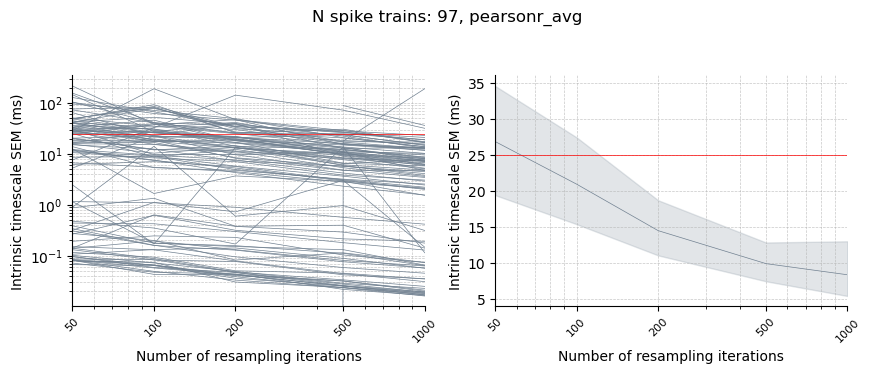

In [12]:
n_iterations_vs_sem(tau_pearsonr_df, 'pearsonr_avg', len(stabilization_pearsonr_df), m_iterations_x_axes)

C:\Users\ipochino\AppData\Local\Temp\ipykernel_17924\2599820166.py:4: UserWarning: 
The palette list has fewer values (1) than needed (97) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(ax=axes[0], data=tau_df_, x="m_iterations", hue='unit_id', y="tau_sem_median_ms", palette=['slategray'], lw=0.5, legend=False)


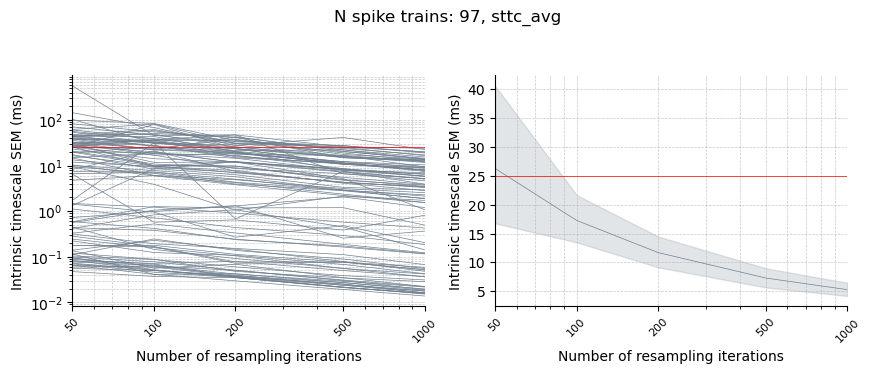

In [13]:
n_iterations_vs_sem(tau_sttc_avg_df, 'sttc_avg', len(stabilization_sttc_avg_df), m_iterations_x_axes)

C:\Users\ipochino\AppData\Local\Temp\ipykernel_17924\2599820166.py:4: UserWarning: 
The palette list has fewer values (1) than needed (97) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(ax=axes[0], data=tau_df_, x="m_iterations", hue='unit_id', y="tau_sem_median_ms", palette=['slategray'], lw=0.5, legend=False)


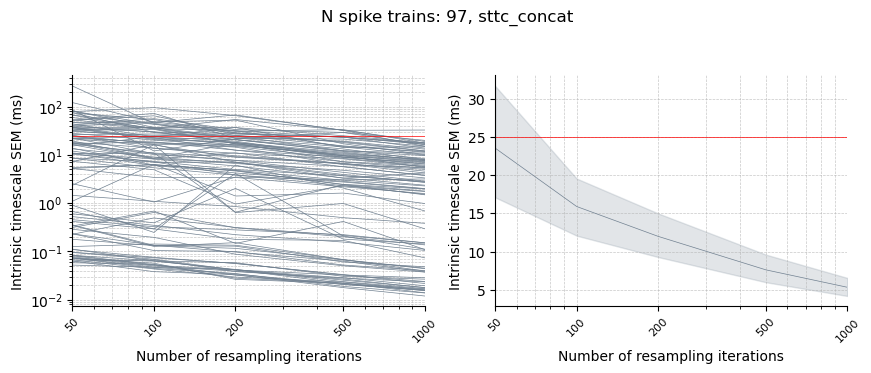

In [14]:
n_iterations_vs_sem(tau_sttc_concat_df, 'sttc_concat', len(stabilization_sttc_concat_df), m_iterations_x_axes)

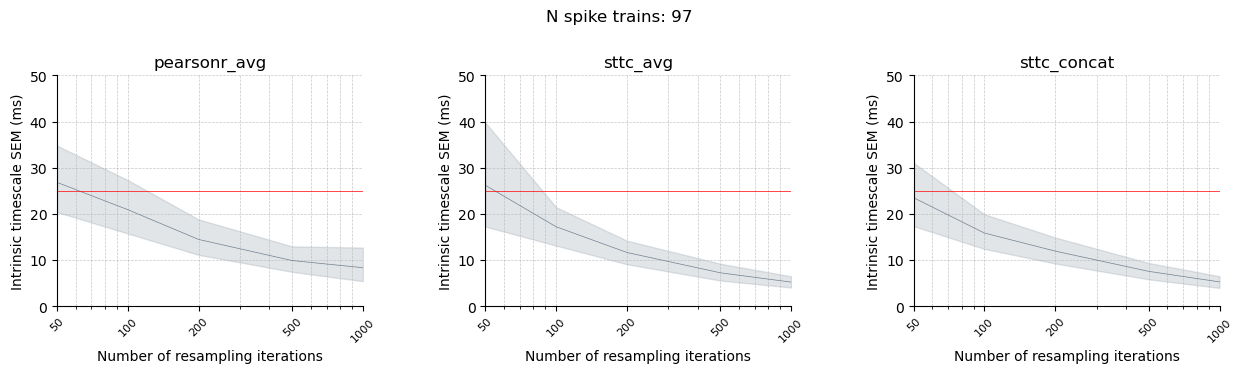

In [15]:
# plot only avg plots for all 2 methods
fig, axes = plt.subplots(1,3,figsize=(15,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.lineplot(ax=axes[0], data=tau_pearsonr_df, x="m_iterations", y="tau_sem_median_ms", color='slategray', lw=0.5, legend=False)
sns.lineplot(ax=axes[1], data=tau_sttc_avg_df, x="m_iterations", y="tau_sem_median_ms", color='slategray', lw=0.5, legend=False)
sns.lineplot(ax=axes[2], data=tau_sttc_concat_df, x="m_iterations", y="tau_sem_median_ms", color='slategray', lw=0.5, legend=False)

axes[0].set_title('pearsonr_avg')
axes[1].set_title('sttc_avg')
axes[2].set_title('sttc_concat')

fig.suptitle(f'N spike trains: {len(stabilization_sttc_concat_df)}', y=1.1)

for ax in axes.flat:
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_xscale('log')
    ax.set_xticks(m_iterations_x_axes)
    ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
    ax.set_xlim([50, 1000])
    ax.set_ylim([0, 50])
    ax.set_xlabel('Number of resampling iterations')
    ax.set_ylabel('Intrinsic timescale SEM (ms)')
    ax.axhline(y=threshold, lw=0.5, color='red')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'n_iterations_vs_sem_all_methods.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_iterations_vs_sem_all_methods.svg' , bbox_inches='tight')

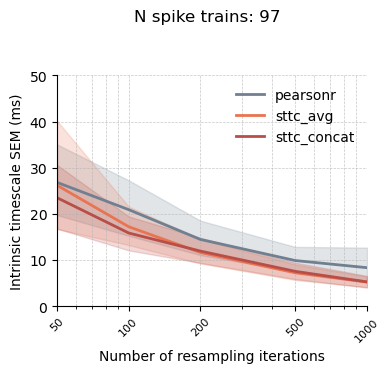

In [16]:
fig, axes = plt.subplots(1,1,figsize=(4,3))

sns.lineplot(ax=axes, data=tau_pearsonr_df, x="m_iterations", y="tau_sem_median_ms", color=color_pearson_trail_avg, lw=2, label='pearsonr')
sns.lineplot(ax=axes, data=tau_sttc_avg_df, x="m_iterations", y="tau_sem_median_ms", color=color_sttc_trail_avg, lw=2, label='sttc_avg')
sns.lineplot(ax=axes, data=tau_sttc_concat_df, x="m_iterations", y="tau_sem_median_ms", color=color_sttc_trail_concat, lw=2, label='sttc_concat')

# axes[0].set_title('pearsonr_avg')
# axes[1].set_title('sttc_avg')
# axes[2].set_title('sttc_concat')

axes.legend(frameon=False)

fig.suptitle(f'N spike trains: {len(stabilization_sttc_concat_df)}', y=1.1)

axes.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
axes.set_xscale('log')
axes.set_xticks(m_iterations_x_axes)
axes.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_xlim([50, 1000])
axes.set_ylim([0, 50])
axes.set_xlabel('Number of resampling iterations')
axes.set_ylabel('Intrinsic timescale SEM (ms)')
#axes.axhline(y=threshold, lw=0.5, color='red')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'n_iterations_vs_sem_all_methods_one_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_iterations_vs_sem_all_methods_one_plot.svg' , bbox_inches='tight')

##### Units reached stab points vs n iterations

In [17]:
def get_plot_dfs(stabilization_df_, m_iterations_x_axes_):
    n_signals = len(stabilization_df_)
    n_signals_below_l = []
    for n_iterations in m_iterations_x_axes_:
        n_signals_below = len(stabilization_df_.query('stabilization_point <= @n_iterations'))
        n_signals_below_l.append(n_signals_below/n_signals * 100)
    
    stab_below_df = pd.DataFrame({
        "m_iterations": m_iterations_x_axes,
        "n_signals_below_perc": n_signals_below_l
    })

    stab_point_count_df = stabilization_df_.groupby(by='stabilization_point', dropna=False, as_index=False).count()
    stab_point_count_df['stabilization_point'] = stab_point_count_df['stabilization_point'].fillna('no')
    stab_point_count_df['stabilization_point'] = pd.Categorical(stab_point_count_df['stabilization_point'], 
                                                                categories=['no', 50, 100, 500, 1000], ordered=True)
    stab_point_count_df_sorted = stab_point_count_df.sort_values(by='stabilization_point')

    return stab_below_df, stab_point_count_df_sorted

In [18]:
def plot_stab_points(stab_below_df_, stab_point_count_df_sorted_, n_units_, method_):
    fig, axes = plt.subplots(1,2,figsize=(10,3))

    sns.barplot(ax=axes[0], x='stabilization_point', y='unit_id', data=stab_point_count_df_sorted_, color='slategray')
    axes[0].set_title('Number of resampling iterations \nwith SEM <= 25ms')
    axes[0].set_ylabel('Number of spike trains')
    
    sns.barplot(ax=axes[1], x='m_iterations', y='n_signals_below_perc', data=stab_below_df_, color='slategray')
    labels = [str(np.round(v, 2)) + '%' if v else '' for v in axes[1].containers[0].datavalues]
    axes[1].bar_label(axes[1].containers[0], labels=labels)
    axes[1].set_title('Percentage of spike trains \nwith SEM <= 25ms')
    axes[1].set_ylabel('Percentage of spike trains')
    axes[1].set_ylim([0, 100])
    axes[1].grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    
    fig.suptitle(f'N spike trains: {n_units_}', y=1.1)
    
    for ax in axes.flat:
         ax.set_xlabel('Number of resampling iterations')
    
    sns.despine()
    
    if save_fig:
        plt.savefig(fig_folder + 'stab_points_' + method_ + '.png' , bbox_inches='tight', dpi=300)
        plt.savefig(fig_folder + 'stab_points_' + method_ + '.svg' , bbox_inches='tight')

In [ ]:
# stab_below_df, stab_point_count_df_sorted = get_plot_dfs(stabilization_df, m_iterations_x_axes)
# plot_stab_points(stab_below_df, stab_point_count_df_sorted, len(stabilization_df))

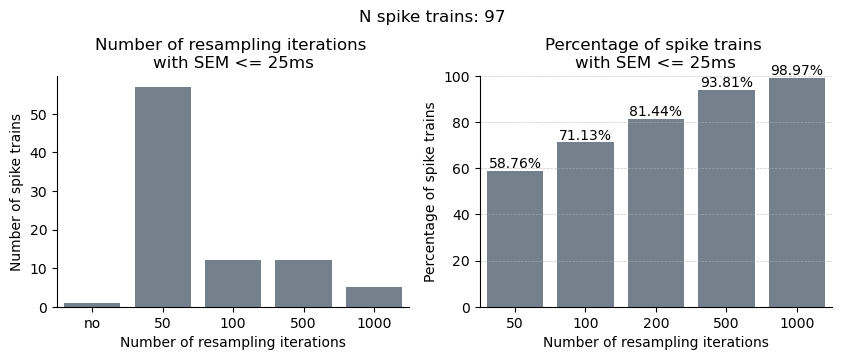

In [19]:
stab_below_pearsonr_df, stab_point_count_pearsonr_df_sorted = get_plot_dfs(stabilization_pearsonr_df, m_iterations_x_axes)
plot_stab_points(stab_below_pearsonr_df, stab_point_count_pearsonr_df_sorted, len(stabilization_pearsonr_df), 'pearsonr_avg')

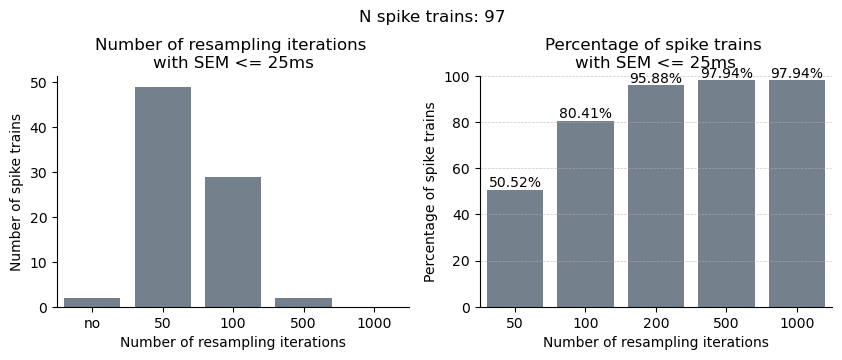

In [20]:
stab_below_pearsonr_rel_df, stab_point_count_pearsonr_rel_df_sorted = get_plot_dfs(stabilization_pearsonr_rel_df, m_iterations_x_axes)
plot_stab_points(stab_below_pearsonr_rel_df, stab_point_count_pearsonr_rel_df_sorted, len(stabilization_pearsonr_rel_df), 'pearsonr_avg_rel')

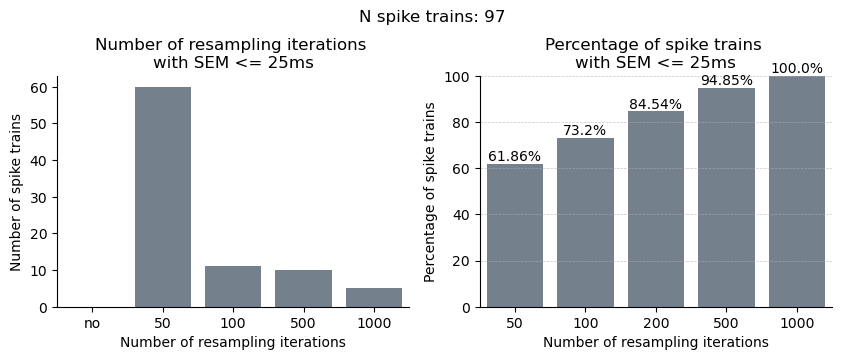

In [21]:
stab_below_sttc_avg_df, stab_point_count_sttc_avg_df_sorted = get_plot_dfs(stabilization_sttc_avg_df, m_iterations_x_axes)
plot_stab_points(stab_below_sttc_avg_df, stab_point_count_sttc_avg_df_sorted, len(stabilization_sttc_avg_df), 'sttc_avg')

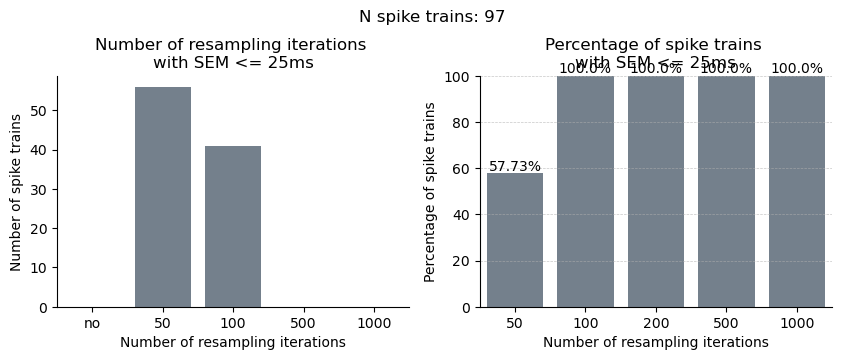

In [22]:
stab_below_sttc_avg_rel_df, stab_point_count_sttc_avg_rel_df_sorted = get_plot_dfs(stabilization_sttc_avg_rel_df, m_iterations_x_axes)
plot_stab_points(stab_below_sttc_avg_rel_df, stab_point_count_sttc_avg_rel_df_sorted, len(stabilization_sttc_avg_rel_df), 'sttc_avg_rel')

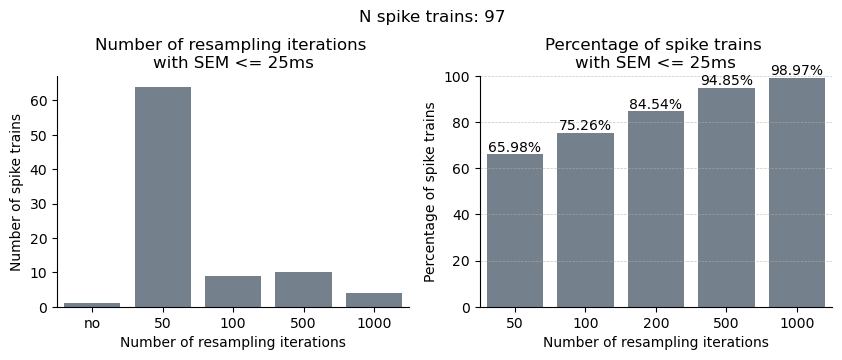

In [23]:
stab_below_sttc_concat_df, stab_point_count_sttc_concat_df_sorted = get_plot_dfs(stabilization_sttc_concat_df, m_iterations_x_axes)
plot_stab_points(stab_below_sttc_concat_df, stab_point_count_sttc_concat_df_sorted, len(stabilization_sttc_concat_df), 'sttc_concat')

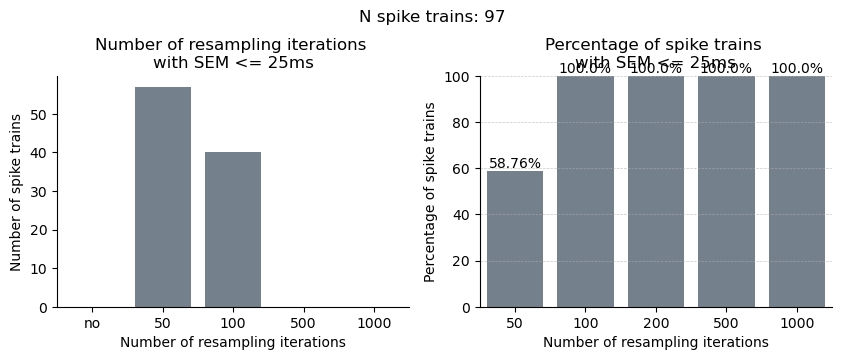

In [24]:
stab_below_sttc_concat_rel_df, stab_point_count_sttc_concat_rel_df_sorted = get_plot_dfs(stabilization_sttc_concat_rel_df, m_iterations_x_axes)
plot_stab_points(stab_below_sttc_concat_rel_df, stab_point_count_sttc_concat_rel_df_sorted, len(stabilization_sttc_concat_rel_df), 'sttc_concat_rel')

In [30]:
# do different rel thresholds: 5%, 10%, 15% of median
rel_thresholds = [0.05, 0.1, 0.15]

rel_threshold_df = pd.DataFrame()
stab_below_rel_df = pd.DataFrame()
for rel_threshold in rel_thresholds:
    stabilization_pearsonr_rel_df_ = get_stabilization_rel_df(tau_pearsonr_df, rel_threshold, units_info_df)
    stabilization_pearsonr_rel_df_['method'] = 'pearsonr_avg'
    stab_below_pearsonr_df_, _ = get_plot_dfs(stabilization_pearsonr_rel_df_, m_iterations_x_axes)
    stab_below_pearsonr_df_['method'] = 'pearsonr_avg'
    
    stabilization_sttc_avg_rel_df_ = get_stabilization_rel_df(tau_sttc_avg_df, rel_threshold, units_info_df)
    stabilization_sttc_avg_rel_df_['method'] = 'sttc_avg'
    stab_below_sttc_avg_rel_df_, _ = get_plot_dfs(stabilization_sttc_avg_rel_df_, m_iterations_x_axes)
    stab_below_sttc_avg_rel_df_['method'] = 'sttc_avg'
    
    stabilization_sttc_concat_rel_df_ = get_stabilization_rel_df(tau_sttc_concat_df, rel_threshold, units_info_df)
    stabilization_sttc_concat_rel_df_['method'] = 'sttc_concat'
    stab_below_sttc_concat_rel_df_, _ = get_plot_dfs(stabilization_sttc_concat_rel_df_, m_iterations_x_axes)
    stab_below_sttc_concat_rel_df_['method'] = 'sttc_concat'
    
    rel_threshold_df_ = pd.concat([stabilization_pearsonr_rel_df_, stabilization_sttc_avg_rel_df_, stabilization_sttc_concat_rel_df_])
    rel_threshold_df_['rel_threshold'] = rel_threshold
    
    rel_threshold_df = pd.concat([rel_threshold_df, rel_threshold_df_])

    stab_below_rel_df_ = pd.concat([stab_below_pearsonr_df_, stab_below_sttc_avg_rel_df_, stab_below_sttc_concat_rel_df_])
    stab_below_rel_df_['rel_threshold'] = rel_threshold
    stab_below_rel_df = pd.concat([stab_below_rel_df, stab_below_rel_df_])

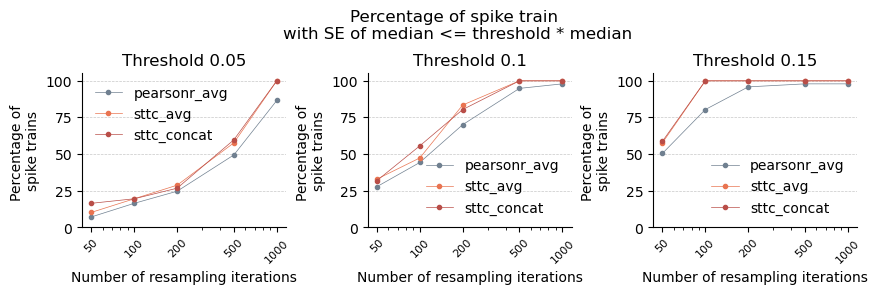

In [55]:
def plot_one_threshold(axes_, threshold_, stab_below_rel_df_):
    axes_.plot(
    stab_below_rel_df_.query('rel_threshold == @threshold_ and method == "pearsonr_avg"')['m_iterations'],
    stab_below_rel_df_.query('rel_threshold == @threshold_ and method == "pearsonr_avg"')['n_signals_below_perc'],
    color=color_pearson_trail_avg, marker='o', markersize=3, linewidth=0.5, label='pearsonr_avg' 
    )
    axes_.plot(
        stab_below_rel_df_.query('rel_threshold == @threshold_ and method == "sttc_avg"')['m_iterations'],
        stab_below_rel_df_.query('rel_threshold == @threshold_ and method == "sttc_avg"')['n_signals_below_perc'],
        color=color_sttc_trail_avg, marker='o', markersize=3, linewidth=0.5, label='sttc_avg'     
    )
    axes_.plot(
        stab_below_rel_df_.query('rel_threshold == @threshold_ and method == "sttc_concat"')['m_iterations'],
        stab_below_rel_df_.query('rel_threshold == @threshold_ and method == "sttc_concat"')['n_signals_below_perc'],
        color=color_sttc_trail_concat, marker='o', markersize=3, linewidth=0.5, label='sttc_concat'          
    )

fig, axes = plt.subplots(1,3,figsize=(10,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], 0.05, stab_below_rel_df)
plot_one_threshold(axes[1], 0.1, stab_below_rel_df)
plot_one_threshold(axes[2], 0.15, stab_below_rel_df)

for ax_idx, ax in enumerate(axes.flat):
    ax.set_xscale('log')
    ax.set_xticks(m_iterations_x_axes)
    ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Number of resampling iterations')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_title(f'Threshold {rel_thresholds[ax_idx]}')
    sns.despine(ax=ax)
    ax.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith SE of median <= threshold * median', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'stab_points_all_methods_rel_thresholds.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'stab_points_all_methods_rel_thresholds.svg' , bbox_inches='tight')

##### Plot per brain area 

In [ ]:
def get_area(area_name, stabilization_df_, m_iterations_x_axes_):
    stabilization_df_area = stabilization_df_.query('ecephys_structure_acronym == @area_name')
    n_signals = len(stabilization_df_area)
    n_signals_below_l = []
    for n_iterations in m_iterations_x_axes_:
        n_signals_below = len(stabilization_df_area.query('stabilization_point <= @n_iterations'))
        n_signals_below_l.append(n_signals_below/n_signals * 100)
    
    stab_below_df = pd.DataFrame({
        "m_iterations": m_iterations_x_axes_,
        "n_signals_below_perc": n_signals_below_l
    })
    return stab_below_df

In [ ]:
def plot_area(areas_, stabilization_df_, m_iterations_x_axes_, method_):
    fig, axes = plt.subplots(2,4,figsize=(16,6))
    plt.subplots_adjust(hspace=0.4, wspace=0.6)
    
    for area_idx, area in enumerate(areas_):
        y_idx = area_idx % 4 
        x_idx = area_idx // 4
    
        stabilization_df_area = get_area(area, stabilization_df_, m_iterations_x_axes_)
        sns.barplot(ax=axes[x_idx,y_idx], x='m_iterations', y='n_signals_below_perc', data=stabilization_df_area, color='slategray')
        labels = [str(np.round(v, 2)) + '%' if v else '' for v in axes[x_idx,y_idx].containers[0].datavalues]
        axes[x_idx,y_idx].bar_label(axes[x_idx,y_idx].containers[0], labels=labels, fontsize=7)
        axes[x_idx,y_idx].set_title(area)
    
    fig.suptitle(f'N spike trains: {len(stabilization_df_)}', y=1)
    
    for ax in axes.flat:
        ax.set_xlabel('Number of resampling iterations')
        ax.set_ylabel('Percentage of spike trains')
        ax.set_ylim([0, 100])
        ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    
    sns.despine()
    
    if save_fig:
        plt.savefig(fig_folder + 'stab_points_per_area_' + method_ + '.png' , bbox_inches='tight', dpi=300)
        plt.savefig(fig_folder + 'stab_points_per_area_' + method_ + '.svg' , bbox_inches='tight')

In [ ]:
areas = stabilization_pearsonr_df['ecephys_structure_acronym'].unique()
areas

In [ ]:
plot_area(areas, stabilization_df, m_iterations_x_axes)

In [ ]:
plot_area(areas, stabilization_pearsonr_df, m_iterations_x_axes, 'pearsonr_avg')

In [ ]:
plot_area(areas, stabilization_sttc_avg_df, m_iterations_x_axes, 'sttc_avg')

In [ ]:
plot_area(areas, stabilization_sttc_concat_df, m_iterations_x_axes, 'sttc_concat')